Import files

# **Recommender System - MovieLens Data analysis**

**by**

# **Cameron Pike**

# **Introduction**

A recommender system functions by predicting a user's rating or preference for an item.There are two types of recommender systems namely Content-based and Collaborative filtering.

Terms:
Item -  is something which is consumed (eg movies)
Users - individuals who interact with the items 
Ratings - eg giving a movie a rating of 3/5

Recommender systems are built by utilising the relationships which exist between items and users. 
These systems require a method to measure how related or similar a user is to another user, or an item is to another item.

In Content-based Filtering, we search to make recommendations based on how similar the properties or features of an ITEM are to other items.

In Collaborative-based filtering we use the similarity measured between USERS to make recommendations.
A Utility Matrix is created where each user is represented as a row and the items (movies) make up features for each user - whether they have rated a movie or not.
We can now measure how similar users are to one another based on their rating characteristics.

A major downside to this approach is a term called 'Cold-start problem'. A new user will have very few ratings.It is possible to filter out these users.

This notebook uses Collaborative-based filtering to predict the rating when provided with the userid and movieid.

# **Load Libraries**

In [1]:
from surprise import Dataset, Reader,  accuracy, SVD, SVDpp

#from funk_svd.dataset import fetch_ml_ratings
#from funk_svd import SVD
from surprise import SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

from surprise.model_selection import train_test_split
import numpy as np
import pandas as pd
#from surprise import SVD
import surprise
import pickle
import random
from surprise.model_selection import cross_validate
import plotly.express as px
from surprise.model_selection import GridSearchCV
#import matplotlib.pyplot as pltd
from matplotlib import pyplot as plt    
import seaborn as sns


/home/bevan/.local/lib/python3.8/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.18.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Import files

Import the files into dataframes

In [2]:
#Note - These files are large and cannot be run fully on Kaggle.The below has been performed on a local Linux pc


##############################
#The correct file for movies
#############################

movies_df = pd.read_csv('/home/bevan/Downloads/movie_recommender/kaggle submissin/unsupervised-predict-streamlit-template-project/resources/data/movies.csv')



##############################
#The correct file for ratings
#############################
ratings_f = pd.read_csv("/home/bevan/Downloads/movie_recommender/kaggle submissin/unsupervised-predict-streamlit-template-project/resources/data/final/train/train.csv")



##############################
#The correct file for sample
#############################

sample = pd.read_csv('/home/bevan/Downloads/movie_recommender/kaggle submissin/unsupervised-predict-streamlit-template-project/resources/data/sample_submission.csv')


######################################################
#As the files are very large test with the below files
######################################################


#################################################################
#The ratings file - random sample
#################################################################

random.seed(4321)
ratings_f = pd.read_csv('/home/bevan/Downloads/movie_recommender/kaggle submissin/unsupervised-predict-streamlit-template-project/resources/data/final/train/train.csv', 
           skiprows=lambda x: x > 0 and random.random() >=0.2)



#################################################################
#The sample file - small file
#################################################################

#sample = pd.read_csv('/home/bevan/Downloads/movie_recommender/kaggle submissin/unsupervised-predict-streamlit-template-project/resources/data/sample_submission_small.csv')




#####################################
#Drop the timestamp column in ratings
#####################################

ratings_f.drop('timestamp',axis=1,inplace=True)


#####################################
#Remove NAN
#####################################

ratings_f = ratings_f.fillna(0)
movies_df = movies_df.fillna(0)









# **Exploratory Data Analysis**

#View the first 5 rows of the ratings data

In [3]:
print(ratings_f.head())

   userId  movieId  rating
0  146790     5459     5.0
1  106362    32296     2.0
2   19630    62049     4.0
3   21066     2282     1.0
4  117563   120474     4.0


#View the first 5 rows of the movie data

In [4]:
print(movies_df.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


View the first 5 rows of the sample data

In [5]:
print(sample.head())

       Id  rating
0  1_2011     1.0
1  1_4144     1.0
2  1_5767     1.0
3  1_6711     1.0
4  1_7318     1.0


#Analyse the columns, shape and data types in the ratings data

#Columns in ratings data

In [6]:
print(ratings_f.columns)

Index(['userId', 'movieId', 'rating'], dtype='object')


#Shape of ratings data

In [7]:
print(ratings_f.shape)

(1999966, 3)


#Info of ratings data

In [8]:
print(ratings_f.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999966 entries, 0 to 1999965
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 45.8 MB
None


#Data types in ratings data

In [9]:
print(ratings_f.dtypes)

userId       int64
movieId      int64
rating     float64
dtype: object


#Count of rows in the ratings data


In [10]:
print('Count of rows in the data is:  ', len(ratings_f))

Count of rows in the data is:   1999966


#Analyse the columns, shape and data types in the movies data

#Columns in movies data

In [11]:
print(movies_df.columns)

Index(['movieId', 'title', 'genres'], dtype='object')


#Shape of movies data


In [12]:
print(movies_df.shape)

(62423, 3)


#Info of movies data

In [13]:
print(movies_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
None


#Data types in movies data

In [14]:
print(movies_df.dtypes)

movieId     int64
title      object
genres     object
dtype: object


#Count of rows in the movies data

In [15]:
print('Count of rows in the data is:  ', len(movies_df))

Count of rows in the data is:   62423


#Total unique movies

In [16]:
total_movies = movies_df['movieId'].unique().tolist()
len(total_movies)

62423

# Visual Analysis

#We can merge the two dataframes on the movieId column since it is common between the two dataframes.

In [17]:
movie_data = pd.merge(ratings_f, movies_df, on='movieId')

movie_data.head()

,userId,movieId,rating,title,genres
0,146790,5459,5.0,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi
1,100026,5459,2.0,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi
2,32562,5459,2.5,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi
3,4402,5459,3.0,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi
4,10019,5459,4.0,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi


#We can now view the average rating of each movie

In [18]:
movie_data.groupby('title')['rating'].mean().head()

title
"Great Performances" Cats (1998)    2.966667
#Female Pleasure (2018)             4.000000
#FollowMe (2019)                    3.000000
#Horror (2015)                      2.750000
#realityhigh (2017)                 3.000000
Name: rating, dtype: float64

#View the total number of ratings for a movie

In [19]:
movie_data.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Shawshank Redemption, The (1994)    6636
Pulp Fiction (1994)                 6352
Forrest Gump (1994)                 6333
Silence of the Lambs, The (1991)    5890
Matrix, The (1999)                  5860
Name: rating, dtype: int64

#count plot for Toy story based on rating

/home/bevan/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rating', ylabel='count'>

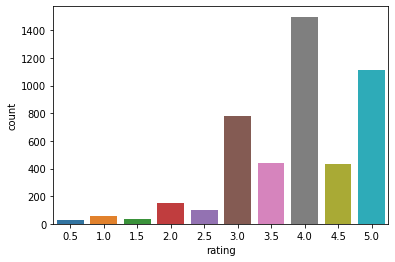

In [20]:

sns.countplot(movie_data.loc[movie_data['title']=='Toy Story (1995)']['rating'])

#Top 25 movies by viewership rating
#finding mean rating of all the movies

#distribution of the rating data

/tmp/ipykernel_6176/3745972293.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


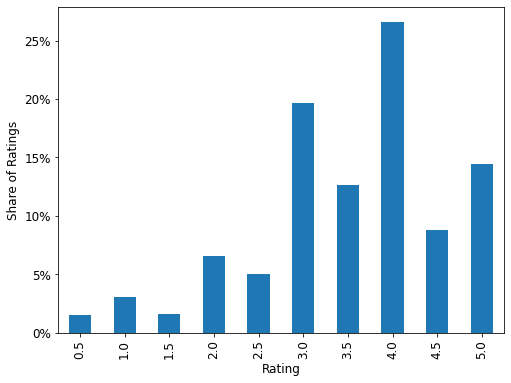

In [21]:
fig = plt.figure()
ax = ratings_f.rating.value_counts(True).sort_index().plot.bar(figsize=(8,6))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Share of Ratings', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig('Ratings_distribution.png')

#Top 25 movies by viewership rating #finding mean rating of all the movies

In [22]:
mean_movies=movie_data.groupby('title')['rating'].agg('mean')

In [23]:
mean_movies.head()

title
"Great Performances" Cats (1998)    2.966667
#Female Pleasure (2018)             4.000000
#FollowMe (2019)                    3.000000
#Horror (2015)                      2.750000
#realityhigh (2017)                 3.000000
Name: rating, dtype: float64

In [24]:
#Top 25 movies
mean_movies.nlargest(25)

title
(Girl)Friend (2018)                               5.0
100 Degrees Below Zero (2013)                     5.0
100 Yen: The Japanese Arcade Experience (2012)    5.0
12 Gifts of Christmas (2015)                      5.0
186 Dollars to Freedom (2012)                     5.0
1971 (2014)                                       5.0
2 Jennifer (2016)                                 5.0
2012: Time for Change (2010)                      5.0
2016: Obama's America (2012)                      5.0
21 Years: Richard Linklater (2014)                5.0
24 Frames (2017)                                  5.0
3-D Sex and Zen: Extreme Ecstasy (2011)           5.0
38 Parrots                                        5.0
5 Doctors (2016)                                  5.0
588 Rue Paradis (Mother) (1992)                   5.0
A Christmas Carol (2015)                          5.0
A Fighting Man (2014)                             5.0
A Gentle Creature (2017)                          5.0
A Gift Horse (2015)   

[Text(0, 0, '(Girl)Friend (2018)'),
 Text(1, 0, '100 Degrees Below Zero (2013)'),
 Text(2, 0, '100 Yen: The Japanese Arcade Experience (2012)'),
 Text(3, 0, '12 Gifts of Christmas (2015)'),
 Text(4, 0, '186 Dollars to Freedom (2012)'),
 Text(5, 0, '1971 (2014)'),
 Text(6, 0, '2 Jennifer (2016)'),
 Text(7, 0, '2012: Time for Change (2010)'),
 Text(8, 0, "2016: Obama's America (2012)"),
 Text(9, 0, '21 Years: Richard Linklater (2014)'),
 Text(10, 0, '24 Frames (2017)'),
 Text(11, 0, '3-D Sex and Zen: Extreme Ecstasy (2011)'),
 Text(12, 0, '38 Parrots'),
 Text(13, 0, '5 Doctors (2016)'),
 Text(14, 0, '588 Rue Paradis (Mother) (1992)'),
 Text(15, 0, 'A Christmas Carol (2015)'),
 Text(16, 0, 'A Fighting Man (2014)'),
 Text(17, 0, 'A Gentle Creature (2017)'),
 Text(18, 0, 'A Gift Horse (2015)'),
 Text(19, 0, 'A Hazard of Hearts (1987)'),
 Text(20, 0, 'A LEGO Brickumentary (2015)'),
 Text(21, 0, 'A Love Affair of Sorts (2011)'),
 Text(22, 0, "A Mother's Nightmare (2012)"),
 Text(23, 0, 'A Mov

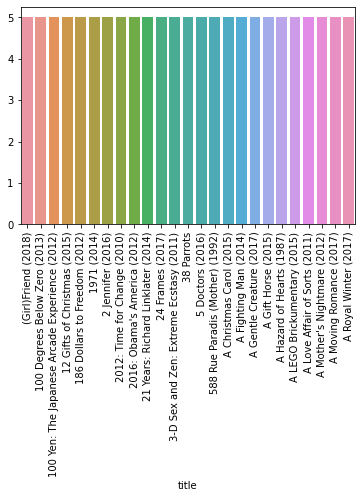

In [25]:
#visualization of top 25 movies based on rating
plot1=sns.barplot(x=mean_movies.nlargest(25).index,y=mean_movies.nlargest(25).values)
plot1.set_xticklabels(plot1.get_xticklabels(),rotation=90)

#Lowest ranked 25 movies

In [26]:
mean_movies.nsmallest(25)

title
(T)ERROR (2015)                                               0.5
11/11/11 (2011)                                               0.5
2001: A Space Travesty (2000)                                 0.5
20th Century Boys - Chapter 1: Beginning of the End (2008)    0.5
4 (2005)                                                      0.5
4 Days (2017)                                                 0.5
44 Pages (2018)                                               0.5
A Brother's Love (2019)                                       0.5
A Connecticut Yankee in King Arthur's Court (1970)            0.5
A Fox's Tale (2008)                                           0.5
A Hidden Life (2019)                                          0.5
Aakrosh (1980)                                                0.5
Aap Mujhe Achche Lagne Lage (2002)                            0.5
Adam Devine: Best Time of Our Lives (2019)                    0.5
Adam and Eve (1983)                                           0.5
Agai

[Text(0, 0, '(T)ERROR (2015)'),
 Text(1, 0, '11/11/11 (2011)'),
 Text(2, 0, '2001: A Space Travesty (2000)'),
 Text(3, 0, '20th Century Boys - Chapter 1: Beginning of the End (2008)'),
 Text(4, 0, '4 (2005)'),
 Text(5, 0, '4 Days (2017)'),
 Text(6, 0, '44 Pages (2018)'),
 Text(7, 0, "A Brother's Love (2019)"),
 Text(8, 0, "A Connecticut Yankee in King Arthur's Court (1970)"),
 Text(9, 0, "A Fox's Tale (2008)"),
 Text(10, 0, 'A Hidden Life (2019)'),
 Text(11, 0, 'Aakrosh (1980)'),
 Text(12, 0, 'Aap Mujhe Achche Lagne Lage (2002)'),
 Text(13, 0, 'Adam Devine: Best Time of Our Lives (2019)'),
 Text(14, 0, 'Adam and Eve (1983)'),
 Text(15, 0, 'Against the Wild (2014)'),
 Text(16, 0, 'Agyaat (2009)'),
 Text(17, 0, 'Air Bud: Spikes Back (2003)'),
 Text(18, 0, 'Al Capone (1959)'),
 Text(19, 0, 'Alleycats (2016)'),
 Text(20, 0, 'Aloft (2014)'),
 Text(21, 0, 'Alone in the Dark II (2008)'),
 Text(22, 0, 'Amateur Porn Star Killer 2 (2008)'),
 Text(23, 0, 'American Poltergeist (2015)'),
 Text(24, 

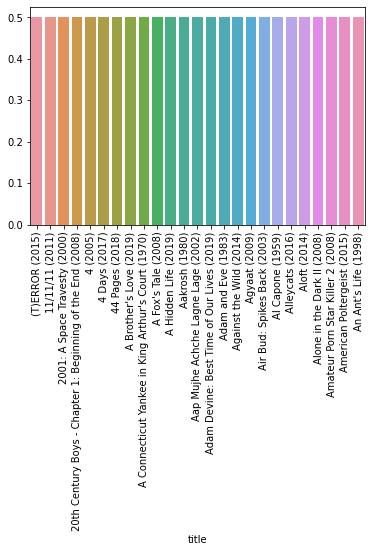

In [27]:
plot1=sns.barplot(x=mean_movies.nsmallest(25).index,y=mean_movies.nsmallest(25).values)
plot1.set_xticklabels(plot1.get_xticklabels(),rotation=90)

# Data preprocessing

#The sample file is in the incorrect format

In [28]:
sample[['Id','movieId']] = sample['Id'].str.split('_',expand=True)
sample = sample[['Id', 'movieId', 'rating']]
sample['Id'] = sample['Id'].astype(int)
sample['movieId'] = sample['movieId'].astype(int)
sample['rating'] = sample['rating'].astype(float)

# **Clean the data**

In [29]:
#No need to clean the data





# Modelling

In [30]:
#Prepare sample data
X_test_sample  = list(sample.itertuples(index=False, name=None))


#Set min and max ratings
min_rat = ratings_f['rating'].min()
max_rat = ratings_f['rating'].max()

# Changing ratings to their standard form
reader = surprise.Reader(rating_scale = (min_rat,max_rat))

# Loading the data frame using surprice
data_load = surprise.Dataset.load_from_df(ratings_f, reader)







#Try different algorithms

In [ ]:
############################
#Grid search using SVD
############################

           
param_grid = {'n_factors': [500, 1000, 2000],
              'n_epochs': [40, 60, 100],
              'lr_all': [0.002, 0.005],
              'reg_all': [0.04, 0.05]}

# Tune algorithm parameters with GridSearchCV and k=3 cross-validation 
gs = GridSearchCV(SVD, param_grid, measures = ['rmse', 'mae'], cv = 3)
gs.fit(data_load)

# Best RMSE and MAE scores

print(gs.best_score)
print("Best scores for SVD")
# Combination of parameters that gave the best scores
print("Best parameters for SVD")
print(gs.best_params)



 




#############################
#BaselineOnly Algorithm
############################

bsl_options = {'method': 'sgd',
               'n_epochs': 200,
               'reg_u': 20,
               'reg_i': 20
               }
method = BaselineOnly(bsl_options=bsl_options)

print("BaselineOnly performance")
print("starting cross validate")       
performs = cross_validate(method, data_load, measures=['RMSE', 'MAE'], cv=3, verbose=True)
print(performs)
print("finished cross validate") 

print("")

#############################
#BaselineOnly Algorithm
############################

bsl_options = {'method': 'sgd',
               'n_epochs': 200,
               'reg_u': 20,
               'reg_i': 20
               }
method = BaselineOnly(bsl_options=bsl_options)

print("BaselineOnly performance")
print("starting cross validate")       
performs = cross_validate(method, data_load, measures=['RMSE', 'MAE'], cv=3, verbose=True)
print(performs)
print("finished cross validate") 
print("")




#############################
#KNNBasic Algorithm
############################

sim_options = {'name': 'msd',
               'user_based': False  # compute  similarities between items
               }
method = KNNBasic(k=30,sim_options=sim_options)


print("KNNBasic performance")
print("starting cross validate")       
performs = cross_validate(method, data_load, measures=['RMSE', 'MAE'], cv=3, verbose=True)
print(performs)
print("finished cross validate") 









 


#Best settings for model

In [ ]:
method = SVD(n_factors = 2000 , lr_all = 0.005 , reg_all = 0.04 , n_epochs = 100 , init_std_dev = 0.01)

# Train the data

In [ ]:
# Loading a trainset into the model

model = method.fit(data_load.build_full_trainset())
#print (f"Training completed. Saving model to: {save_path}")
    
print("starting cross validate")       
performs = cross_validate(method, data_load, measures=['RMSE', 'MAE'], cv=3, verbose=True)
print(performs)
print("finished cross validate")   


# Predict

In [ ]:
predictions = method.test(X_test_sample)
#print(predictions)




prediction_output = pd.DataFrame (predictions, columns = ['uid', 'iid', 'r_ui', 'est', 'details'])
prediction_output = prediction_output.drop(['details'], axis=1)
prediction_output = prediction_output.drop(['r_ui'], axis=1)


cols = ['uid', 'iid']
prediction_output['Id'] = prediction_output[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
prediction_output['rating'] = prediction_output['est']

prediction_output = prediction_output.drop(['uid'], axis=1)
prediction_output = prediction_output.drop(['iid'], axis=1)
prediction_output = prediction_output.drop(['est'], axis=1)
prediction_output = prediction_output[['Id', 'rating']]




#This is the correct one to save file
prediction_output.to_csv('testsubmission.csv', index=False)   
